In [2]:
import ooipy
import Welch_Percentile as wp
import datetime

In [3]:
start = datetime.datetime(2019,1,12,2,30,0)
end = datetime.datetime(2019,1,12,3,30,0)

data = ooipy.get_acoustic_data(start, end, node='LJ01C')

In [26]:
spec_wp = compute_spectrogram_wp(data.data, data.stats, avg_time=1.0, percentile=0.8)

In [13]:
from ooipy.tools import ooiplotlib as ooiplt

/home/fschwock/anaconda3/envs/ooipy_ready/lib/python3.8/site-packages/ooipy/tools/ooiplotlib.py:191: UserWarning: The following kwargs were not used by contour: 'plot', 'save', 'filename', 'title', 'xlabel', 'xlabel_rot', 'xlabel_format', 'ylabel', 'fmin', 'fmax', 'vdelta', 'vdelta_cbar', 'figsize', 'res_reduction_time', 'res_reduction_freq'
  im = ax.contourf(t, f, np.transpose(v), cbarticks,


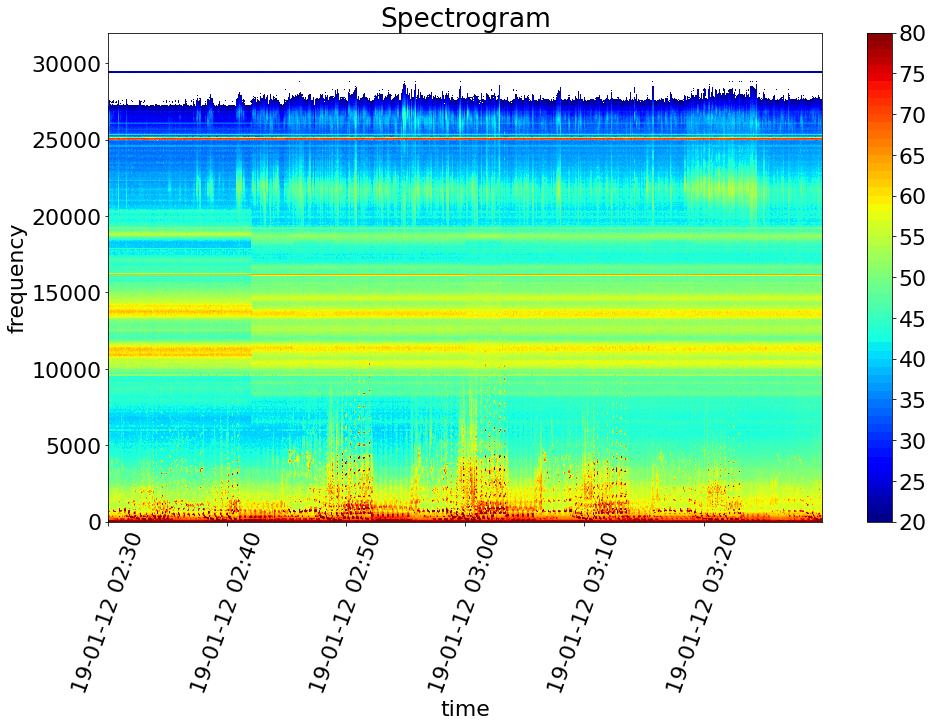

In [27]:
ooiplt.plot_spectrogram(spec_wp)

In [38]:
# NOT WORKING YET!!!
spec_wp_mp = compute_spectrogram_wp_mp(data, avg_time=1.0, percentile=0.8)

KeyboardInterrupt: 

In [37]:
from ooipy.hydrophone.basic import HydrophoneData
import multiprocessing as mp
from obspy.core import UTCDateTime

def compute_spectrogram_wp_mp(hyd_data, n_process=None, win='hann', L=4096,
                           avg_time=None, overlap=0.5, verbose=False, percentile=0.5):
    """
    Same as function compute_spectrogram but using multiprocessing.
    This function is intended to be used when analyzing large data sets.
    Parameters
    ----------
    n_process : int, optional
        Number of processes in the pool. None (default) means that
        n_process is equal to the number of CPU cores.
    win : str, optional
        Window function used to taper the data.
        See scipy.signal.get_window for a list of possible window functions
        (Default is Hann-window.)
    L : int, optional
        Length of each data block for computing the FFT (Default is 4096).
    avg_time : float, optional
        Time in seconds that is covered in one time step of the
        spectrogram. Default value is None and one time step covers L
        samples. If the signal covers a long time period it is recommended
        to use a higher value for avg_time to avoid memory overflows and
        to facilitate visualization.
    overlap : float, optional
        Percentage of overlap between adjacent blocks if Welch's method
        is used. Parameter is ignored if avg_time is None. (Default is 50%)
    verbose : bool, optional
        If true (defult), exception messages and some comments are printed.
    Returns
    -------
    Spectrogram
        A Spectrogram object that contains time and frequency bins as well
        as corresponding values. If no noise date is available,
        None is returned.
    """

    # create array with N start and end time values
    if n_process is None:
        N = mp.cpu_count()
    else:
        N = n_process

    ooi_hyd_data_list = []
    seconds_per_process = (hyd_data.stats.endtime - hyd_data.stats.starttime) / N
    for k in range(N - 1):
        starttime = hyd_data.stats.starttime + datetime.timedelta(
            seconds=k * seconds_per_process)
        endtime = hyd_data.stats.starttime + datetime.timedelta(
            seconds=(k + 1) * seconds_per_process)
        temp_slice = hyd_data.slice(starttime=UTCDateTime(starttime),
                                endtime=UTCDateTime(endtime))
        tmp_obj = HydrophoneData(data=temp_slice.data,
                                 header=temp_slice.stats,
                                 node=hyd_data.stats.location)
        ooi_hyd_data_list.append((tmp_obj, win, L, avg_time, overlap, verbose, percentile))

    starttime = hyd_data.stats.starttime + datetime.timedelta(
        seconds=(N - 1) * seconds_per_process)
    temp_slice = hyd_data.slice(starttime=UTCDateTime(starttime),
                            endtime=UTCDateTime(hyd_data.stats.endtime))
    tmp_obj = HydrophoneData(data=temp_slice.data, header=temp_slice.stats,
                             node=hyd_data.stats.location)
    ooi_hyd_data_list.append((tmp_obj, win, L, avg_time, overlap, verbose, percentile))

    with mp.get_context("spawn").Pool(n_process) as p:
        try:
            specgram_list = p.starmap(_spectrogram_mp_helper,
                                      ooi_hyd_data_list)
            # concatenate all small spectrograms to
            # obtain final spectrogram
            specgram = []
            time_specgram = []
            for i in range(len(specgram_list)):
                time_specgram.extend(specgram_list[i].time)
                specgram.extend(specgram_list[i].values)
            spectrogram = Spectrogram(np.array(time_specgram),
                                           specgram_list[0].freq,
                                           np.array(specgram))
            return spectrogram
        except Exception:
            if verbose:
                print('Cannot compute spectrogram')
            spectrogram = None
            return None
        
def _spectrogram_mp_helper(ooi_hyd_data_obj, win, L, avg_time, overlap, verbose, percentile):
    """
    Helper function for compute_spectrogram_mp
    """
    spec = compute_spectrogram_wp(ooi_hyd_data_obj.data, ooi_hyd_data_obj.stats,
                                  win, L, avg_time, overlap, verbose, percentile)
    return spec

In [31]:
import datetime

import numpy as np
import ooipy
from scipy import signal
import os
import pandas as pd
from scipy.interpolate import interp1d

def compute_spectrogram_wp(data, stats, win='hann', L=4096, avg_time=None,
                           overlap=0.5, verbose=True, percentile=0.5):
    """
    Compute spectrogram of acoustic signal. For each time step of the
    spectrogram either a modified periodogram (avg_time=None)
    or a power spectral density estimate using Welch's method with median
    averaging is computed.

    Parameters
    ----------
    win : str, optional
        Window function used to taper the data. See scipy.signal.get_window
        for a list of possible window functions (Default is Hann-window.)
    L : int, optional
        Length of each data block for computing the FFT (Default is 4096).
    avg_time : float, optional
        Time in seconds that is covered in one time step of the
        spectrogram. Default value is None and one time step covers L
        samples. If the signal covers a long time period it is recommended
        to use a higher value for avg_time to avoid memory overflows and
        to facilitate visualization.
    overlap : float, optional
        Percentage of overlap between adjacent blocks if Welch's method is
        used. Parameter is ignored if avg_time is None. (Default is 50%)
    verbose : bool, optional
        If true (defult), exception messages and some comments are printed.

    Returns
    -------
    Spectrogram
        A Spectrogram object that contains time and frequency bins as
        well as corresponding values. If no noise date is available,
        None is returned.
    """
    specgram = []
    time = []

    if any(data) is None:
        if verbose:
            print('Data object is empty. Spectrogram cannot be computed')
        spectrogram = None
        return None

    # sampling frequency
    fs = stats.sampling_rate

    # number of time steps
    if avg_time is None:
        nbins = int((len(data) - L) / ((1 - overlap) * L)) + 1
    else:
        nbins = int(np.ceil(len(data) / (avg_time * fs)))

    # compute spectrogram. For avg_time=None
    # (periodogram for each time step), the last data samples are ignored
    # if len(noise[0].data) != k * L
    if avg_time is None:
        n_hop = int(L * (1 - overlap))
        for n in range(nbins):
            # f, Pxx, Nb = welch_percentile(x=self.data[n * n_hop:n * n_hop + L],
            #    bias_func=bias_digamma_approx, fs=fs, window=win, nperseg=L,
            #    overlap=0.5, nfft=L, percentile=percentile)
            f, Pxx = signal.periodogram(
                x=data[n * n_hop:n * n_hop + L],
                fs=fs, window=win)
            if len(Pxx) != int(L / 2) + 1:
                if verbose:
                    print('Error while computing periodogram for segment',
                          n)
                spectrogram = None
                return None
            else:
                sense_corr = -frequency_calibration(stats, int(L / 2 + 1))

                Pxx = 10 * np.log10(Pxx * np.power(10, sense_corr / 10))

                specgram.append(Pxx)
                time.append(stats.starttime.datetime
                            + datetime.timedelta(seconds=n * L / fs))

    else:
        for n in range(nbins - 1):
            f, Pxx, Nb = welch_percentile(x=data[n * int(fs * avg_time):
                                                      (n + 1) * int(fs * avg_time)],
                                          bias_func=bias_digamma_approx, fs=fs, window=win, nperseg=L,
                                          overlap=0.5, nfft=L, percentile=percentile)
            # f, Pxx = signal.welch(
            #    x=self.data[n * int(fs * avg_time):
            #                (n + 1) * int(fs * avg_time)],
            #    fs=fs, window=win, nperseg=L, noverlap=int(L * overlap),
            #    nfft=L, average='median')

            if len(Pxx) != int(L / 2) + 1:
                if verbose:
                    print('Error while computing '
                          'Welch estimate for segment', n)
                spectrogram = None
                return None
            else:
                sense_corr = -frequency_calibration(stats, int(L / 2 + 1))

                Pxx = 10 * np.log10(Pxx * np.power(10, sense_corr / 10))
                specgram.append(Pxx)
                time.append(stats.starttime.datetime
                            + datetime.timedelta(seconds=n * avg_time))

        # compute PSD for residual segment
        # if segment has more than L samples
        if len(data[int((nbins - 1) * fs * avg_time):]) >= L:
            f, Pxx, Nb = welch_percentile(x=data[int((nbins - 1) * fs * avg_time):],
                                          bias_func=bias_digamma_approx, fs=fs, window=win, nperseg=L,
                                          overlap=0.5, nfft=L, percentile=percentile)
            # f, Pxx = signal.welch(
            #    x=self.data[int((nbins - 1) * fs * avg_time):],
            #    fs=fs, window=win, nperseg=L, noverlap=int(L * overlap),
            #    nfft=L, average='median')
            if len(Pxx) != int(L / 2) + 1:
                if verbose:
                    print(
                        'Error while computing Welch '
                        'estimate residual segment')
                spectrogram = None
                return None
            else:
                sense_corr = -frequency_calibration(stats, int(L / 2 + 1))

                Pxx = 10 * np.log10(Pxx * np.power(10, sense_corr / 10))
                specgram.append(Pxx)
                time.append(stats.starttime.datetime
                            + datetime.timedelta(seconds=(nbins - 1)
                                                 * avg_time))

    if len(time) == 0:
        if verbose:
            print('Spectrogram does not contain any data')
        spectrogram = None
        return None
    else:
        spectrogram = Spectrogram(np.array(time), np.array(f),
                                       np.array(specgram))
        return spectrogram

# TODO: use correct frequency response for all hydrophones
def frequency_calibration(stats, N):
    # TODO
    """
    Apply a frequency dependent sensitivity correction to the
    acoustic data based on the information from the calibration
    sheets.
    TODO Add for all broadband hydrophones
    !!! Currently only implemented for Oregon Offshore Base Seafloor
    and Oregon Shelf Base Seafloor hydrophone. For all other
    hydrophones, an average sensitivity of -169dBV/1uPa is assumed
    !!!

    Parameters
    ----------
    N : int
        length of the data segment

    Returns
    -------
    output_array : np.array
        array with correction coefficient for every frequency
    """
    # Load calibation file and get appropriate calibration info

    filename = '/home/fschwock/Desktop/ooipy-data-analysis/data-retrieval/calibration_by_assetID.csv' # TODO
    # Use deployment CSV to determine asset_ID
    assetID = get_asset_ID(stats)

    # load calibration data as pandas dataframe
    cal_by_assetID = pd.read_csv(filename, header=[0, 1])

    f_calib = cal_by_assetID[assetID]['Freq (kHz)'].to_numpy() * 1000
    sens_calib_0 = cal_by_assetID[assetID]['0 phase'].to_numpy()
    sens_calib_90 = cal_by_assetID[assetID]['90 phase'].to_numpy()
    sens_calib = 0.5 * (sens_calib_0 + sens_calib_90)
    f = np.linspace(0, round(stats.sampling_rate / 2), N)

    # Convert calibration to correct units
    if round(stats.sampling_rate) == 200:
        sens_calib = 20 * np.log10(sens_calib * 1e-6)
    elif round(stats.sampling_rate) == 64000:
        sens_calib = sens_calib + 128.9
    else:
        raise Exception('Invalid sampling rate')

    sens_interpolated = interp1d(f_calib, sens_calib)

    f_calib = sens_interpolated(f)
    return f_calib

def get_asset_ID(stats):
    '''
    get_asset_ID returns the hydrophone asset ID for a given data sample.
    This data can be foun `here <https://raw.githubusercontent.com/
    OOI-CabledArray/deployments/main/HYDBBA_deployments.csv'>`_ for
    broadband hydrophones. Since Low frequency hydrophones remain
    constant with location and time, if the hydrophone is low frequency,
    the node ID is returned
    '''
    # Low frequency hydrophone
    if round(stats.sampling_rate) == 200:
        asset_ID = stats.location

    elif round(stats.sampling_rate) == 64000:
        url = 'https://raw.githubusercontent.com/OOI-CabledArray/' \
            'deployments/main/HYDBBA_deployments.csv'
        hyd_df = pd.read_csv(url)

        # LJ01D'Oregon Shelf Base Seafloor
        if stats.location == 'LJ01D':
            ref = 'CE02SHBP-LJ01D-11-HYDBBA106'
        # LJ01AOregon Slope Base Seafloor
        if stats.location == 'LJ01A':
            ref = 'RS01SLBS-LJ01A-09-HYDBBA102'
        # Oregan Slope Base Shallow
        if stats.location == 'PC01A':
            ref = 'RS01SBPS-PC01A-08-HYDBBA103'
        # Axial Base Shallow Profiler
        if stats.location == 'PC03A':
            ref = 'RS03AXPS-PC03A-08-HYDBBA303'
        # Oregon Offshore Base Seafloor
        if stats.location == 'LJ01C':
            ref = 'CE04OSBP-LJ01C-11-HYDBBA105'
        # Axial Base Seafloor
        if stats.location == 'LJ03A':
            ref = 'RS03AXBS-LJ03A-09-HYDBBA302'

        hyd_df['referenceDesignator']

        df_ref = hyd_df.loc[hyd_df['referenceDesignator'] == ref]

        df_start = df_ref.loc[(df_ref['startTime'] < stats.starttime)
                              & (df_ref['endTime']
                              > stats.starttime)]
        df_end = df_ref.loc[(df_ref['startTime'] < stats.endtime) &
                            (df_ref['endTime'] > stats.endtime)]

        if df_start.index.to_numpy() == df_end.index.to_numpy():
            idx = df_start.index.to_numpy()
            asset_ID = df_start['assetID'][int(idx)]
        else:
            raise Exception('Hydrophone Data involves multiple'
                            'deployments. Feature to be added later')
    else:
        raise Exception('Invalid hydrophone sampling rate')

    return asset_ID


def welch_percentile(x, bias_func, fs=1.0, window='hann', nperseg=None, overlap=None, nfft=None,
                     detrend='constant', return_onesided=True, scaling='density',
                     axis=-1, percentile=None, numRV='edof'):

    freqs, _, Pxy = signal.spectral._spectral_helper(x, x, fs, window, nperseg, int(nperseg * overlap), nfft,
                                                     detrend, return_onesided, scaling, axis,
                                                     mode='psd')

    Nb = Pxy.shape[-1]

    if len(Pxy.shape) >= 2 and Pxy.size > 0:
        if Pxy.shape[-1] > 1:
            if percentile == None:
                Pxy = Pxy.mean(axis=-1)
            elif isinstance(percentile, int) or isinstance(percentile, float):
                if percentile >= 0 and percentile <= 1:

                    if numRV == 'n':
                        Pxy = np.quantile(Pxy, percentile, axis=-1) / bias_func(Pxy.shape[-1], percentile)
                    elif numRV == 'edof':
                        win = signal.get_window(window, nperseg) / np.sqrt(
                            np.sum(signal.get_window(window, nperseg) ** 2))
                        edof = compute_nu(len(x), nperseg, win, overlap)
                        if bias_func == bias_digamma_approx:
                            Pxy = np.quantile(Pxy, percentile, axis=-1) / bias_func(edof / 2, percentile)
                        else:
                            Pxy = np.quantile(Pxy, percentile, axis=-1) / bias_func(int(np.round(edof / 2)), percentile)
                else:
                    raise ValueError('percentile must be between 0 and 1, got %s'
                                     % (percentile,))
            else:
                raise ValueError('percentile must be integer, float, or None type, got type %s'
                                 % (type(percentile),))
        else:
            Pxy = np.reshape(Pxy, Pxy.shape[:-1])

    return freqs, Pxy, Nb

def compute_nu(N, Ns, win, o):
    Nb = int(N/(Ns*(1-o)))
    def _sum_win(win, Ns, m, o):
        win_s = np.roll(win, -int((1-o)*Ns)*m)
        win_s[-int((1-o)*Ns)*m:] = 0
        return abs(np.sum(win * win_s))**2
    sum_denom = 0
    for m in np.linspace(1, Nb-1, Nb-1, dtype=int):
        sum_denom += (1 - m/Nb)*_sum_win(win, Ns, m, o)
    nu = 2*Nb / (1 + 2 * sum_denom)
    return nu


def bias_alternating_harmonic_series(N, p):
    l = np.linspace(1, N, N)
    return np.sum((-1) ** (l + 1) / l)


def bias_truncated_harmonic_series(N, p):
    percentiles = np.round(np.linspace(1 / (N + 1), 1 - 1 / (N + 1), N), 3)
    if p in percentiles:
        l = np.arange(np.round((N - 1) * (1 - p)) + 1, N + 1, 1)
    else:
        l = np.arange(np.round(N * (1 - p)) + 1, N + 2, 1)
    return np.sum(1 / l)


def bias_digamma_approx(N, p):
    def digamma(x):
        return np.log(x) - 1 / (2 * x) - 1 / (12 * x ** 2) + 1 / (120 * x ** 4) - 1 / (252 * x ** 6)

    return digamma(N + 2) - digamma(N * (1 - p) + 1)


def no_bias_correct(N, p):
    return 1.0


def bias_limit(N, p):
    return -np.log(1 - p)

class Spectrogram:
    """
    A class used to represent a spectrogram object.

    Attributes
    ----------
    time : 1-D array of float or datetime objects
        Indices of time-bins of spectrogram.
    freq : 1-D array of float
        Indices of frequency-bins of spectrogram.
    values : 2-D array of float
        Values of the spectrogram. For each time-frequency-bin pair there has
        to be one entry in values. That is, if time has  length N and freq
        length M, values is a NxM array.

    """

    def __init__(self, time, freq, values):
        self.time = time
        self.freq = freq
        self.values = values

    def visualize(self, plot_spec=True, save_spec=False,
                  filename='spectrogram.png', title='spectrogram',
                  xlabel='time', xlabel_rot=70, ylabel='frequency', fmin=0,
                  fmax=32000, vmin=20, vmax=80, vdelta=1.0,
                  vdelta_cbar=5, figsize=(16, 9), dpi=96, res_reduction_time=1,
                  res_reduction_freq=1, time_limits=None):
        """
        This function will be depreciated into a differnt module in the future.
        The current documentation might not be accurate.

        To plot spectrograms please see
        :meth:`ooipy.hydrophone.basic.plot_spectrogram`

        Basic visualization of spectrogram based on matplotlib. The function
        offers two options: Plot spectrogram in Python (plot_spec = True) and
        save spectrogram plot in directory (save_spec = True). Spectrograms are
        plotted in dB re 1µ Pa^2/Hz.

        plot_spec (bool): whether or not spectrogram is plotted using Python
        save_spec (bool): whether or not spectrogram plot is saved
        filename (str): directory where spectrogram plot is saved. Use ending
        ".png" or ".pdf" to save as PNG or PDF file. This value will be ignored
        if save_spec=False
        title (str): title of plot
        ylabel (str): label of vertical axis
        xlabel (str): label of horizontal axis
        xlabel_rot (float): rotation of xlabel. This is useful if xlabel are
        longer strings for example when using datetime.datetime objects.
        fmin (float): minimum frequency (unit same as f) that is displayed
        fmax (float): maximum frequency (unit same as f) that is displayed
        vmin (float): minimum value (dB) of spectrogram that is colored.
        All values below are displayed in white.
        vmax (float): maximum value (dB) of spectrogram that is colored.
        All values above are displayed in white.
        vdelta (float): color resolution
        vdelta_cbar (int): label ticks in colorbar are in vdelta_cbar steps
        figsize (tuple(int)): size of figure
        dpi (int): dots per inch
        time_limits : list
            specifices xlimits on spectrogram. List contains two
            datetime.datetime objects
        """
        import warnings
        raise warnings.warn('will be depricated in future. Please see '
                            'ooipy.tools.ooiplotlib.plot_spectrogram()')
        # set backend for plotting/saving:
        if not plot_spec:
            matplotlib.use('Agg')

        font = {'size': 22}
        matplotlib.rc('font', **font)

        v = self.values[::res_reduction_time, ::res_reduction_freq]

        if len(self.time) != len(self.values):
            t = np.linspace(0, len(self.values) - 1,
                            int(len(self.values) / res_reduction_time))
        else:
            t = self.time[::res_reduction_time]

        # Convert t to np.array of datetime.datetime
        if type(t[0]) == UTCDateTime:
            for k in range(len(t)):
                t[k] = t[k].datetime

        if len(self.freq) != len(self.values[0]):
            f = np.linspace(0, len(self.values[0]) - 1,
                            int(len(self.values[0]) / res_reduction_freq))
        else:
            f = self.freq[::res_reduction_freq]

        cbarticks = np.arange(vmin, vmax + vdelta, vdelta)
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        im = ax.contourf(t, f, np.transpose(v), cbarticks,
                         norm=colors.Normalize(vmin=vmin, vmax=vmax),
                         cmap=plt.cm.jet)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.ylim([fmin, fmax])
        if time_limits is not None:
            plt.xlim(time_limits)
        plt.xticks(rotation=xlabel_rot)
        plt.title(title)
        plt.colorbar(im, ax=ax,
                     ticks=np.arange(vmin, vmax + vdelta, vdelta_cbar))
        plt.tick_params(axis='y')

        if type(t[0]) == datetime.datetime:
            ax.xaxis.set_major_formatter(
                mdates.DateFormatter('%y-%m-%d %H:%M'))

        if save_spec:
            plt.savefig(filename, dpi=dpi, bbox_inches='tight')

        if plot_spec:
            plt.show()
        else:
            plt.close(fig)